# Linear Collider Detector Calorimeter Data Visualization


**Calorimetry and the LCD Detector**

In high energy physics, detectors are used to take 'images' of particles that may result from controlled particle collisions (such as the Large Hadron Collider), single beams of known particles (such as test beams or neutrino beams), or influxes of particles from natural sources (such as solar neutrinos). These images are taken by advanced technologies exploiting the different methods in which particles interact with matter. 

The calorimeter is one class of detectors that is used to capture (aka reconstruct) the energy of passing particles. This is done by using materials that the particles will interact with, essentially emitting energy in this exchange, and materials that can tell us the amount of energy that is lost. Through consecutive processes of interactions and energy loss the goal is for particles to effectively stop in the material and for the reconstructed energy to be a measure of the initial energy of the particle.  For example in the ATLAS detector, one calorimeter system uses plates of steel (a dense material) to 'slow down and stop' the passing particles inside the calorimeter, alternating with plates of plastic scintillator that ionize as these high energy particles pass. The photons emitted during the ionization process are collected onto photomultiplier tubes which convert the photon into an electrical signal representative of the lost energy. As particles interact with the calorimeter showers of secondary particles are produced, themselves interacting with the material, and so on. In particle physics experiments the purpose of the calorimeter is to precisely reconstruct the energy and identification of initial particle initiating this shower.      
One potential future high energy physics experiment is an electron-positron linear collider. R&D is underway to design and build that accelerator facility and associated detectors. The linear collider detector (LCD) is one of these proposed detectors. The LCD design includes the standard components including inner tracking detectors, calorimeters, and outer tracking systems. 

In this analysis we will use simulations of the LCD calorimeter system, made up of an electromagnetic calorimeter (ECAL) and hadronic calorimeter (HCAL). The ECAL aims to fully reconstruct the energy from electrons, positrons, and photons, and to measure the initial energy of showers initiated by hadrons. The ECAL is highly granular (in this simulation broken down into 25x25x25 cells) to help differentiate between electron (positron) and photon particles by properties of their shower developments, and to help identify incoming photons that converted into electron-position pairs. The HCAL is highly granular along the longitudinal direction (in this simulation separated into 5x5x60 cells), giving more information about the longitudinal development of hadronic showers. The LCD calorimeters are non-compensating, meaning there are ways in which hadrons lose energy in the interactions that are not captured in the reconstruction of the electrical signal. Hence downstream software corrections must be applied to hadron showers to accurately reconstuct the initial hadron energy. The amount of the correction depends on several factors, including the initial particle energy and type. 

**The LCD Dataset**

In this example simulated particles of either electrons, photons, neutral pions, or charged pions are shot directly into the LCD calorimeter systems. The cell level information (physical positions, energy deposited) is saved for the ECAL (25x25x25) and HCAL (5x5x60), thus saving a 3D image for each 'event' (event = single particle). The goal is to study the use of deep learning methods to improve the identification and reconstruction of these particles.   

The dataset is divided into four directories, each storing a large number of h5 files that hold images for one specific particle type. During training, our tools will appropriate mix and label this dataset. For this visualization exercise, we will use a premixed single 22 GB. Let's start by opening the dataset and explore its contents:

(Running in Jupyter Notebooks: click on the box below and hit shift-enter.)


In [1]:
import os
import sys
import h5py

FileName='/data/LCD/LCD-Merged-All.h5'

file = h5py.File(FileName, 'r')

for k in file.keys():
    try:
        print k,file[k].shape
    except:
        print k,"Not a tensor"

    
#file.close()

ECAL (3211264, 25, 25, 25)
HCAL (3211264, 5, 5, 60)
OneHot (3211264, 4)
index (3211264,)
target (3211264, 1, 5)


The output shows there are 3211264 events, which will require several hundred GB of RAM to load into memory. The ECAL and HCAL are as described above. The groups "index" and "OneHot" encode the four particle types as an index or 4 "bits". "target" holds the true energy of the particle.

**The Classification Problem**

One function of the LCD calorimeter is to efficiently distinguish between different particle types so reconstruction software can apply the appropriate energy correction factors. We can examine by-eye the properties of the four different particles provided in our simulated dataset.

The script below reads in the LCD dataset and attempts to visualize the 3D images of one electron and one pion event to show how qualitatively these appear differently. Instead of plotting the 3D image, the images are plotted in 2D showing the cells in the x and y position. For fixed x and y values, the values for the energy deposted in each cell along the longitudinal direction (z) are summed and displayed in the 3rd axis. The color and size of a circle at a given x and y position represent the total amount of energy summed along the longitudinal direction. 

The ECAL is so highly granular that looping over the 25x25x25 tensor is too memory intensive, hence for this demonstrative visual purpose we are only considering 4x4x25 cells. For an actual analysis where access to GPUs is possible, one should consider the full tensor to maximize the classification ability.


-- Starting LCD calorimeter event visualization --
Found the following events to visualize:
     Electron: evt# =  3  energy =  477.202
     Pion    : evt# =  4  energy =  482.191


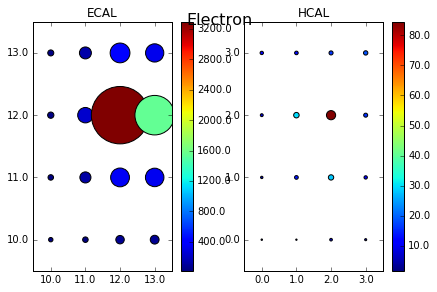

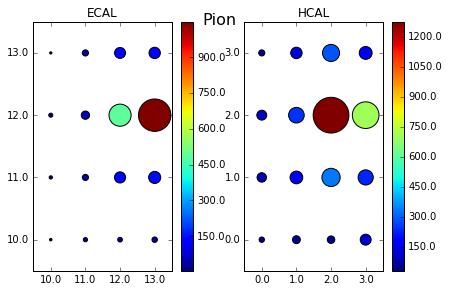

In [2]:
print "-- Starting LCD calorimeter event visualization --"

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#-- user settings
minEnergy=400 # find electron and pion event with at least 400 GeV of energy
#-- end user settings

ecal = file["ECAL"]
hcal = file["HCAL"]
onehot = file["OneHot"]
index = file["index"]
target = file["target"]

#-- pick one event from each particle type and plot the ECAL and HCAL response maps

# find the index of an *electron* event (with energy greater than the minimum value) and associated energy
indexElEvt = -999
energyElEvt = -999
for evt in range(0,len(index)):
    energy=target[evt][0][1]
    if( (onehot[evt][1] ==1.0) and (energy > minEnergy)  ): 
        indexElEvt = evt
        energyElEvt = energy
        break # end for loop
        
# find the index of a *pion* event (with energy greater than the minimum value) 
indexPiEvt = -999
energyPiEvt = -999
for evt in range(0,len(index)):
    energy = target[evt][0][1]
    if( (onehot[evt][2] ==1.0) and ( energy > minEnergy) ):
        indexPiEvt = evt
        energyPiEvt = energy  
        break # end for loop

                
print "Found the following events to visualize:"
print "     Electron: evt# = ", indexElEvt, " energy = ", energyElEvt
print "     Pion    : evt# = ", indexPiEvt, " energy = ", energyPiEvt
 
# arguments:
#   evtNum = event index
#   ec=ecal, hc=hcal
#   title= main title for both figures
def PlotCalorimeters(evtNum, ec, hc, title):
    # make two plots side-by-side showing ECAL and HCAL
    # will collapse longitudinal layers into the scatter plot
    # Note: plotting limited dimensions in Ecal (25x25x25 very slow)

    #-- Fill arrays for plotting
    # ECAL
    sumZAxisEcal = []
    xaxisEcal = []
    yaxisEcal = []

    startIndexEcal=10 #over x,y
    endIndexEcal=14

    for x in range(startIndexEcal,endIndexEcal):    
        for y in range (startIndexEcal,endIndexEcal):
            xaxisEcal.append(x)
            yaxisEcal.append(y)
            sumZEcal = 0
            for z in range (0,24): # over all z
                sumZEcal += ecal[evtNum,x,y,z] 
                # end for over z
            sumZAxisEcal.append(sumZEcal)
            #end for over y     
        # end for over x


    # HCAL
    sumZAxisHcal = []
    xaxisHcal = []
    yaxisHcal = []

    startIndexHcal=0 #over x,y
    endIndexHcal=4

    for x in range(startIndexHcal,endIndexHcal):  
        for y in range (startIndexHcal,endIndexHcal):
            xaxisHcal.append(x)
            yaxisHcal.append(y)
            sumZHcal = 0
            for z in range (0,60): # over all z
                sumZHcal += hcal[evtNum,x,y,z]
                # end for over z
            sumZAxisHcal.append(sumZHcal)
            #end for over y     
        # end for over x

    #-- Plotting
    from matplotlib.ticker import FormatStrFormatter

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    scatEcal = ax1.scatter(xaxisEcal,yaxisEcal,s=sumZAxisEcal,c=sumZAxisEcal )
    fig.colorbar(scatEcal, ax=ax1,format='%.1f')
    ax1.set_title('ECAL')
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.xaxis.set_ticks(np.arange(startIndexEcal, endIndexEcal, 1.0))
    ax1.yaxis.set_ticks(np.arange(startIndexEcal, endIndexEcal, 1.0))

    scatHcal = ax2.scatter(xaxisHcal,yaxisHcal,s=sumZAxisHcal,c=sumZAxisHcal )
    fig.colorbar(scatHcal, ax=ax2,format='%.1f')
    ax2.set_title('HCAL')
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2.xaxis.set_ticks(np.arange(startIndexHcal, endIndexHcal, 1.0))
    ax2.yaxis.set_ticks(np.arange(startIndexHcal, endIndexHcal, 1.0))

    plt.suptitle(title,size=16)
    plt.show()

    
PlotCalorimeters(indexElEvt, ecal, hcal, 'Electron')
PlotCalorimeters(indexPiEvt, ecal, hcal, 'Pion')


file.close()


The figures on the top show the ECAL (left) and HCAL (right) energy deposits for an electron event. One can see that for even high energy electrons the bulk of the energy is deposited in the ECAL, with very litte in the HCAL. The bottom figures show the same ECAL and HCAL energy deposits for a pion event. In this case pions deposit energy in both the ECAL and HCAL. The electron and pion events above have similar initial energies. 

In general this behavior of electrons depositing most energy in the ECAL and 

It is not feasible to scan by-eye the calorimeter response, so instead algorithms are trained to classify the particle types. In this example we will study deep learning hyper-parameters to determine which parameters best classify these types of events in the LCD calorimeter. 

**Other Deep Learning Problems**

- simulation based on data
- energy regression
